Diffusion Models¶
Diffusion models are powerful tools for data generation, and understanding their construction process is crucial.

- Here's a breakdown of the key steps involved:

1. Defining the Diffusion Process:

Forward Diffusion: Choose a method to gradually add noise to your data (e.g., Gaussian noise, channel dropout).
Define how noise level increases with each step, creating a path from clean data to pure noise.
Target Distribution: Specify the target data distribution you want to approximate (e.g., natural images, specific text styles).

2. Model Architecture:

Denoising Model: Design a neural network capable of predicting the "correction" needed to remove noise at each step, gradually revealing the underlying data structure, Popular choices include U-Nets, Transformers, and autoencoders.
Loss Function: Choose a metric to measure the difference between the model's predicted correction and the actual noise, guiding the training process. Common options include mean squared error or perceptual losses.

3. Training:

Dataset: Prepare a dataset of clean data from your target distribution.
Optimization: Select an optimizer (e.g., Adam) and set hyperparameters like learning rate and batch size.
Training Loop: Iterate through steps:
Sample clean data and add noise according to the diffusion process.
Feed the noisy data to the denoising model.
Calculate the loss between predicted correction and true noise.
Backpropagate the loss to update model weights.

4. Sampling:

Start with Noise: Begin with pure noise representing the highest noise level.
Iterative Denoising: At each step:
Pass the current noisy sample and its noise level to the trained model.
Apply the predicted correction to reduce noise and move closer to clean data.
Repeat for a fixed number of steps.
Final Output: The final denoised sample should ideally resemble data from your target distribution.


In [176]:
from typing import Dict, Tuple
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import models, transforms
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np
from IPython.display import HTML
from torchvision.utils import save_image, make_grid
import os
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from PIL import Image
import kagglehub

device = "cuda" if torch.cuda.is_available() else "cpu"

Building Context UNet.

In [177]:
class ResidualConvBlock(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, is_res: bool = False
    ) -> None:
        super().__init__()

        # Check if input and output channels are the same for the residual connection
        self.same_channels = in_channels == out_channels

        # Flag for whether or not to use residual connection
        self.is_res = is_res

        # First convolutional layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),   # 3x3 kernel with stride 1 and padding 1
            nn.BatchNorm2d(out_channels),   # Batch normalization
            nn.GELU(),   # GELU activation function
        )

        # Second convolutional layer
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),   # 3x3 kernel with stride 1 and padding 1
            nn.BatchNorm2d(out_channels),   # Batch normalization
            nn.GELU(),   # GELU activation function
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        # If using residual connection
        if self.is_res:
            # Apply first convolutional layer
            x1 = self.conv1(x)

            # Apply second convolutional layer
            x2 = self.conv2(x1)

            # If input and output channels are the same, add residual connection directly
            if self.same_channels:
                out = x + x2
            else:
                # If not, apply a 1x1 convolutional layer to match dimensions before adding residual connection
                shortcut = nn.Conv2d(x.shape[1], x2.shape[1], kernel_size=1, stride=1, padding=0).to(x.device)
                out = shortcut(x) + x2
            #print(f"resconv forward: x {x.shape}, x1 {x1.shape}, x2 {x2.shape}, out {out.shape}")

            # Normalize output tensor
            return out / 1.414

        # If not using residual connection, return output of second convolutional layer
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2

    # Method to get the number of output channels for this block
    def get_out_channels(self):
        return self.conv2[0].out_channels

    # Method to set the number of output channels for this block
    def set_out_channels(self, out_channels):
        self.conv1[0].out_channels = out_channels
        self.conv2[0].in_channels = out_channels
        self.conv2[0].out_channels = out_channels

        

class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()
        
        # Create a list of layers for the upsampling block
        # The block consists of a ConvTranspose2d layer for upsampling, followed by two ResidualConvBlock layers
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
        ]
        
        # Use the layers to create a sequential model
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        # Concatenate the input tensor x with the skip connection tensor along the channel dimension
        x = torch.cat((x, skip), 1)
        
        # Pass the concatenated tensor through the sequential model and return the output
        x = self.model(x)
        return x

    
class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()
        
        # Create a list of layers for the downsampling block
        # Each block consists of two ResidualConvBlock layers, followed by a MaxPool2d layer for downsampling
        layers = [ResidualConvBlock(in_channels, out_channels), ResidualConvBlock(out_channels, out_channels), nn.MaxPool2d(2)]
        
        # Use the layers to create a sequential model
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        # Pass the input through the sequential model and return the output
        return self.model(x)

class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        '''
        This class defines a generic one layer feed-forward neural network for embedding input data of
        dimensionality input_dim to an embedding space of dimensionality emb_dim.
        '''
        self.input_dim = input_dim
        
        # define the layers for the network
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]
        
        # create a PyTorch sequential model consisting of the defined layers
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        # flatten the input tensor
        x = x.view(-1, self.input_dim)
        # apply the model layers to the flattened tensor
        return self.model(x)
    
def unorm(x):
    # unity norm. results in range of [0,1]
    # assume x (h,w,3)
    xmax = x.max((0,1))
    xmin = x.min((0,1))
    return(x - xmin)/(xmax - xmin)

def norm_all(store, n_t, n_s):
    # runs unity norm on all timesteps of all samples
    nstore = np.zeros_like(store)
    for t in range(n_t):
        for s in range(n_s):
            nstore[t,s] = unorm(store[t,s])
    return nstore

def norm_torch(x_all):
    # runs unity norm on all timesteps of all samples
    # input is (n_samples, 3,h,w), the torch image format
    x = x_all.cpu().numpy()
    xmax = x.max((2,3))
    xmin = x.min((2,3))
    xmax = np.expand_dims(xmax,(2,3)) 
    xmin = np.expand_dims(xmin,(2,3))
    nstore = (x - xmin)/(xmax - xmin)
    return torch.from_numpy(nstore)

def gen_tst_context(n_cfeat):
    """
    Generate test context vectors for Minecraft items
    10 categories: Utility, Decorative, Wood, Plant, Stone, Potion, Food, Tool, Spawn Egg, Light Source
    """
    vec = torch.tensor([
        # 6 samples per category: 5 of that type + 1 null/random
        [1,0,0,0,0,0,0,0,0,0], [1,0,0,0,0,0,0,0,0,0], [1,0,0,0,0,0,0,0,0,0], [1,0,0,0,0,0,0,0,0,0], [1,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0],  # Utility
        [0,1,0,0,0,0,0,0,0,0], [0,1,0,0,0,0,0,0,0,0], [0,1,0,0,0,0,0,0,0,0], [0,1,0,0,0,0,0,0,0,0], [0,1,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0],  # Decorative
        [0,0,1,0,0,0,0,0,0,0], [0,0,1,0,0,0,0,0,0,0], [0,0,1,0,0,0,0,0,0,0], [0,0,1,0,0,0,0,0,0,0], [0,0,1,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0],  # Wood
        [0,0,0,1,0,0,0,0,0,0], [0,0,0,1,0,0,0,0,0,0], [0,0,0,1,0,0,0,0,0,0], [0,0,0,1,0,0,0,0,0,0], [0,0,0,1,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0],  # Plant
        [0,0,0,0,1,0,0,0,0,0], [0,0,0,0,1,0,0,0,0,0], [0,0,0,0,1,0,0,0,0,0], [0,0,0,0,1,0,0,0,0,0], [0,0,0,0,1,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0],  # Stone
        [0,0,0,0,0,1,0,0,0,0], [0,0,0,0,0,1,0,0,0,0], [0,0,0,0,0,1,0,0,0,0], [0,0,0,0,0,1,0,0,0,0], [0,0,0,0,0,1,0,0,0,0], [0,0,0,0,0,0,0,0,0,0],  # Potion
        [0,0,0,0,0,0,1,0,0,0], [0,0,0,0,0,0,1,0,0,0], [0,0,0,0,0,0,1,0,0,0], [0,0,0,0,0,0,1,0,0,0], [0,0,0,0,0,0,1,0,0,0], [0,0,0,0,0,0,0,0,0,0],  # Food
        [0,0,0,0,0,0,0,1,0,0], [0,0,0,0,0,0,0,1,0,0], [0,0,0,0,0,0,0,1,0,0], [0,0,0,0,0,0,0,1,0,0], [0,0,0,0,0,0,0,1,0,0], [0,0,0,0,0,0,0,0,0,0],  # Tool
        [0,0,0,0,0,0,0,0,1,0], [0,0,0,0,0,0,0,0,1,0], [0,0,0,0,0,0,0,0,1,0], [0,0,0,0,0,0,0,0,1,0], [0,0,0,0,0,0,0,0,1,0], [0,0,0,0,0,0,0,0,0,0],  # Spawn Egg
        [0,0,0,0,0,0,0,0,0,1], [0,0,0,0,0,0,0,0,0,1], [0,0,0,0,0,0,0,0,0,1], [0,0,0,0,0,0,0,0,0,1], [0,0,0,0,0,0,0,0,0,1], [0,0,0,0,0,0,0,0,0,0],  # Light Source
    ])
    return len(vec), vec

def plot_grid(x,n_sample,n_rows,save_dir,w):
    # x:(n_sample, 3, h, w)
    ncols = n_sample//n_rows
    grid = make_grid(norm_torch(x), nrow=ncols)  # curiously, nrow is number of columns.. or number of items in the row.
    save_image(grid, save_dir + f"run_image_w{w}.png")
    print('saved image at ' + save_dir + f"run_image_w{w}.png")
    return grid

def plot_sample(x_gen_store,n_sample,nrows,save_dir, fn,  w, save=False):
    ncols = n_sample//nrows
    sx_gen_store = np.moveaxis(x_gen_store,2,4)                               # change to Numpy image format (h,w,channels) vs (channels,h,w)
    nsx_gen_store = norm_all(sx_gen_store, sx_gen_store.shape[0], n_sample)   # unity norm to put in range [0,1] for np.imshow
    
    # create gif of images evolving over time, based on x_gen_store
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True,figsize=(ncols,nrows))
    def animate_diff(i, store):
        print(f'gif animating frame {i} of {store.shape[0]}', end='\r')
        plots = []
        for row in range(nrows):
            for col in range(ncols):
                axs[row, col].clear()
                axs[row, col].set_xticks([])
                axs[row, col].set_yticks([])
                plots.append(axs[row, col].imshow(store[i,(row*ncols)+col]))
        return plots
    ani = FuncAnimation(fig, animate_diff, fargs=[nsx_gen_store],  interval=200, blit=False, repeat=True, frames=nsx_gen_store.shape[0]) 
    plt.close()
    if save:
        ani.save(save_dir + f"{fn}_w{w}.gif", dpi=100, writer=PillowWriter(fps=5))
        print('saved gif at ' + save_dir + f"{fn}_w{w}.gif")
    return ani


class CustomDataset(Dataset):
    def __init__(self, sfilename, lfilename, transform, null_context=False):
        self.sprites = np.load(sfilename)
        self.slabels = np.load(lfilename)
        print(f"sprite shape: {self.sprites.shape}")
        print(f"labels shape: {self.slabels.shape}")
        self.transform = transform
        self.null_context = null_context
        self.sprites_shape = self.sprites.shape
        self.slabel_shape = self.slabels.shape
                
    # Return the number of images in the dataset
    def __len__(self):
        return len(self.sprites)
    
    # Get the image and label at a given index
    def __getitem__(self, idx):
        # Return the image and label as a tuple
        if self.transform:
            image = self.transform(self.sprites[idx])
            if self.null_context:
                label = torch.tensor(0).to(torch.int64)
            else:
                label = torch.tensor(self.slabels[idx]).to(torch.int64)
        return (image, label)

    def getshapes(self):
        # return shapes of data and labels
        return self.sprites_shape, self.slabel_shape

transform = transforms.Compose([
    transforms.ToTensor(),                # from [0,255] to range [0.0,1.0]
    transforms.Normalize((0.5,), (0.5,))  # range [-1,1]

])

In [178]:
class ContextUnet(nn.Module):
    def __init__(self, in_channels, n_feat=256, n_cfeat=10, height=28):  # cfeat - context features
        super(ContextUnet, self).__init__()

        # number of input channels, number of intermediate feature maps and number of classes
        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_cfeat = n_cfeat
        self.h = height  #assume h == w. must be divisible by 4, so 28,24,20,16...

        # Initialize the initial convolutional layer
        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)

        # Initialize the down-sampling path of the U-Net with two levels
        self.down1 = UnetDown(n_feat, n_feat)        # down1 #[10, 256, 8, 8]
        self.down2 = UnetDown(n_feat, 2 * n_feat)    # down2 #[10, 256, 4,  4]
        
         # original: self.to_vec = nn.Sequential(nn.AvgPool2d(7), nn.GELU())
        self.to_vec = nn.Sequential(nn.AvgPool2d((4)), nn.GELU())

        # Embed the timestep and context labels with a one-layer fully connected neural network
        self.timeembed1 = EmbedFC(1, 2*n_feat)
        self.timeembed2 = EmbedFC(1, 1*n_feat)
        self.contextembed1 = EmbedFC(n_cfeat, 2*n_feat)
        self.contextembed2 = EmbedFC(n_cfeat, 1*n_feat)

        # Initialize the up-sampling path of the U-Net with three levels
        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, self.h//4, self.h//4), # up-sample 
            nn.GroupNorm(8, 2 * n_feat), # normalize                        
            nn.ReLU(),
        )
        self.up1 = UnetUp(4 * n_feat, n_feat)
        self.up2 = UnetUp(2 * n_feat, n_feat)

        # Initialize the final convolutional layers to map to the same number of channels as the input image
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1), # reduce number of feature maps   #in_channels, out_channels, kernel_size, stride=1, padding=0
            nn.GroupNorm(8, n_feat), # normalize
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1), # map to same number of channels as input
        )

    def forward(self, x, t, c=None):
        """
        x : (batch, n_feat, h, w) : input image
        t : (batch, n_cfeat)      : time step
        c : (batch, n_classes)    : context label
        """
        # x is the input image, c is the context label, t is the timestep, context_mask says which samples to block the context on

        # pass the input image through the initial convolutional layer
        x = self.init_conv(x)
        # pass the result through the down-sampling path
        down1 = self.down1(x)       #[10, 256, 8, 8]
        down2 = self.down2(down1)   #[10, 256, 4, 4]
        
        # convert the feature maps to a vector and apply an activation
        hiddenvec = self.to_vec(down2)
        
        # mask out context if context_mask == 1
        if c is None:
            c = torch.zeros(x.shape[0], self.n_cfeat).to(x)
            
        # embed context and timestep
        cemb1 = self.contextembed1(c).view(-1, self.n_feat * 2, 1, 1)     # (batch, 2*n_feat, 1,1)
        temb1 = self.timeembed1(t).view(-1, self.n_feat * 2, 1, 1)
        cemb2 = self.contextembed2(c).view(-1, self.n_feat, 1, 1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat, 1, 1)
        #print(f"uunet forward: cemb1 {cemb1.shape}. temb1 {temb1.shape}, cemb2 {cemb2.shape}. temb2 {temb2.shape}")


        up1 = self.up0(hiddenvec)
        up2 = self.up1(cemb1*up1 + temb1, down2)  # add and multiply embeddings
        up3 = self.up2(cemb2*up2 + temb2, down1)
        out = self.out(torch.cat((up3, x), 1))
        return out

Model Hyperparameters.

In [179]:
# hyperparameters

# diffusion hyperparameters
timesteps = 500
beta1 = 1e-4
beta2 = 0.02

# network hyperparameters
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
n_feat = 64 # 64 hidden dimension feature
n_cfeat = 10 # context vector is of size 5
height = 16 # 16x16 image
save_dir = '/kaggle/working/'

# training hyperparameters
batch_size = 32
n_epoch = 50
lrate=1e-4
num_augmentations = 7

In [180]:
# construct DDPM noise schedule
b_t = (beta2 - beta1) * torch.linspace(0, 1, timesteps + 1, device=device) + beta1
a_t = 1 - b_t
ab_t = torch.cumsum(a_t.log(), dim=0).exp()    
ab_t[0] = 1

def perturb_input(x, t, noise):
    # t must be long for indexing
    t = t.long()
    # DDPM forward diffusion:
    # x_t = sqrt(ab_t) * x_0 + sqrt(1 - ab_t) * noise
    return (
        ab_t[t, None, None, None].sqrt() * x +
        (1 - ab_t[t, None, None, None]).sqrt() * noise
    )

Constructing Model.

In [181]:
nn_model = ContextUnet(in_channels=3, n_feat=n_feat, n_cfeat=n_cfeat, height=height).to(device)

## Loading Dataset.

In [182]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from PIL import Image, ImageEnhance
import io

# Load the dataset from parquet
splits = {'train': 'data/train-00000-of-00001-fa0b6bb53e3b3d16.parquet', 
          'validation': 'data/validation-00000-of-00001-49f45a5ed0b4ad18.parquet', 
          'test': 'data/test-00000-of-00001-48d445de0e368b7c.parquet'}

df = pd.read_parquet("hf://datasets/James-A/Minecraft-16x-Dataset/" + splits["train"])

print("DataFrame shape (before filtering):", df.shape)
print("DataFrame columns:", df.columns.tolist())

df.head()

DataFrame shape (before filtering): (1366, 19)
DataFrame columns: ['image', 'texture_name', 'texture_size', 'type', 'primary_colors', 'secondary_colors', 'pattern_description', 'texture_style', 'lighting_reflection', 'symmetry', 'tileable_direction', 'visual_complexity', 'illumination_effects', 'usage_context', 'functionality', 'related_items_blocks', 'mimicry_biome_association', 'special_effects_in_game_functionality', 'overall_texture_description']


,image,texture_name,texture_size,type,primary_colors,secondary_colors,pattern_description,texture_style,lighting_reflection,symmetry,tileable_direction,visual_complexity,illumination_effects,usage_context,functionality,related_items_blocks,mimicry_biome_association,special_effects_in_game_functionality,overall_texture_description
0,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,Acacia Trapdoor,16x16,"Block - Wood, Utility","Warm Brown (RGB: [169, 92, 51])","Dark Brown (RGB: [101, 56, 31]), Gray (RGB: [6...",The texture displays a warm brown wooden plank...,Pixelated,Uniform Reflection. The simulation of uniforml...,Symmetrical,Tileable both vertically and horizontally,"Low. The design is straightforward, with repet...",None,"Building, decoration, security (can be used as...","Can be opened or closed by players, may intera...","Acacia Door, Acacia Planks, Acacia Slab, Acaci...",Mimics a wooden trapdoor made from acacia wood...,None,A 16x16 pixel art block texture depicting an A...
1,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,Amethyst Cluster,16x16,"Block - Mineral, Decorative","Medium Purple (RGB: [134, 103, 172])","Light Purple (RGB: [189, 160, 221]), Yellow (R...","Sharp, angular crystalline structures reminisc...",Pixelated,Directional Reflection. Brighter highlights on...,Non-symmetrical,Non-tileable,"Medium, with varied geometrical shapes and ref...",None,"Decoration, crafting, light-diffusing block in...",Decorative and can be harvested for Amethyst S...,"Amethyst Shard, Budding Amethyst, Amethyst Blo...",Mimics real-world amethyst crystal clusters an...,None,A 16x16 pixel art block texture displaying an ...
2,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,Ancient Debris Side,16x16,Block - Ore,"Dark Brown (RGB: [74, 44, 42])","Lighter Brown (RGB: [113, 66, 65]), Cream (RGB...",Camouflaged pattern with speckles and streaks ...,Pixelated,Uniform Reflection. The texture displays an ev...,Non-symmetrical,Tileable both vertically and horizontally,"High, due to the intricate camouflaged pattern...",None,"Building, Crafting (used to refine into the hi...","Non-decorative, primarily used in the smelting...","Netherite Block, Netherite Ingot, Netherite Sc...","Mimics an ore-rich rock, specific to the Nethe...","No special visual effects, used in smelting to...",A 16x16 pixel art block texture depicting the ...
3,"{'bytes': b""\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...",Ancient Debris Top,16x16,Block - Ore,"Dark Brown (RGB: [77, 49, 49])","Medium Brown (RGB: [96, 60, 60]), Light Gray (...",Concentric square and rectangular shapes creat...,Pixelated,Directional Reflection. The texture displays s...,Symmetrical,Tileable both vertically and horizontally,"Medium. The texture has a structured, detailed...",None,"Mining, smithing, building.",Used for crafting high-tier materials and equi...,"Netherite Scrap, Netherite Block, Netherite In...",Mimics a complex mineral-like pattern and is a...,None,A 16x16 pixel art block texture of ancient deb...
4,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,Anvil Base,16x16,"Block - Utility, Metal","Dark Gray (RGB: [54, 54, 54])","Lighter Gray (RGB: [76, 76, 76]), Very Dark Gr...",Variegated gray texture with splotches and spe...,Pixelated with a noise pattern to simulate wea...,Spotted Reflection. The texture includes light...,Non-symmetrical,Non-tileable as it represents a specific part ...,"Medium, due to variations in gray to simulate ...",None,"Crafting, utility, repairing tools and armor.","Provides the functionality to repair items, re...","Anvil, Slightly Damaged Anvil, Very Damaged An...","Mimics the look of a forged metal anvil, not a...",None beyond the crafting and repairing functio...,A 16x16 pixel art block texture representing t...


In [183]:
# Filter for rows
# df = df[df['type'].str.contains('ore', case=False, na=False)]

# Get all unique types from the 'type' column
def extract_unique_types(df):
    """
    Extract all unique type values from the 'type' column.
    Format: "Block - Type1, Type2, Type3"
    """
    all_types = set()
    
    for type_str in df['type']:
        if pd.isna(type_str):
            continue
        
        # Split by " - " to separate "Block" from the types
        parts = type_str.split(' - ')
        
        if len(parts) > 1:
            # Get the types part (after "Block - ")
            types_part = parts[1]
            
            # Split by comma to get individual types
            individual_types = [t.strip() for t in types_part.split(',')]
            
            # Add to set
            all_types.update(individual_types)
    
    return sorted(list(all_types))

In [184]:
# Extract unique types
unique_types = extract_unique_types(df)

print(f"\nTotal unique types: {len(unique_types)}")
print("\nAll unique types:")
for i, type_name in enumerate(unique_types, 1):
    print(f"{i}. {type_name}")


Total unique types: 165

All unique types:
1. Accessory
2. Agricultural
3. Agriculture
4. Ammunition
5. Apparel
6. Aquatic
7. Aquatic creature
8. Armor
9. Armor Component
10. Armor Trim
11. Armor UI Component
12. Armor Upgrade
13. Armor Upgrade Component
14. Artifact
15. Barrier
16. Bed
17. Bottle
18. Brewing Ingredient
19. Building
20. Building Material
21. Building material
22. Ceramic
23. Clay
24. Clay-Based
25. Cloth
26. Colorant
27. Combat
28. Concrete Powder
29. Construction Material
30. Consumable
31. Container
32. Coral
33. Craft
34. Craftable
35. Crafted Material
36. Crafted Wood
37. Crafting
38. Crafting Component
39. Crafting Ingredient
40. Crafting Material
41. Creature
42. Creature-related
43. Crop
44. Decoration
45. Decorative
46. Decorative Plant
47. Dirt
48. Dye
49. Earth
50. Educational
51. Effect
52. Egg
53. Enchanted
54. End-themed
55. Entertainment
56. Entity
57. Entity Drop
58. Entity Summoner
59. Entity-related
60. Equipment
61. Equippable
62. Explosive
63. Farmi

In [185]:
# Optional: Count frequency of each type
def count_type_frequencies(df):
    """Count how many times each type appears"""
    type_counts = {}
    
    for type_str in df['type']:
        if pd.isna(type_str):
            continue
        
        parts = type_str.split(' - ')
        if len(parts) > 1:
            types_part = parts[1]
            individual_types = [t.strip() for t in types_part.split(',')]
            
            for t in individual_types:
                type_counts[t] = type_counts.get(t, 0) + 1
    
    return type_counts

# Get frequency counts
type_frequencies = count_type_frequencies(df)

In [186]:
print("\n\nType frequencies (sorted by count):")
for type_name, count in sorted(type_frequencies.items(), key=lambda x: x[1], reverse=True):
    print(f"{type_name}: {count}")



Type frequencies (sorted by count):
Utility: 378
Decorative: 255
Wood: 147
Plant: 144
Stone: 126
Potion: 62
Food: 56
Tool: 51
Spawn Egg: 46
Light Source: 39
Building: 33
Metal: 32
Armor: 29
Transparent: 27
Organic: 27
Glass: 26
Redstone: 25
Ore: 23
Artifact: 21
Transportation: 21
Combat: 21
Natural: 20
Furniture: 19
Aquatic: 19
Building Material: 18
Ceramic: 18
Dye: 18
Crop: 17
Mineral: 15
Egg: 15
Consumable: 15
Weapon: 12
Music Disc: 11
Earth: 10
Crafting Material: 10
Brewing Ingredient: 9
Clay: 8
Storage: 8
Soil: 8
Textile: 8
Container: 7
Terra Cotta: 7
Nature: 6
Ice: 6
Powder: 6
Underwater: 5
Crafting Component: 5
Nether: 4
Mechanical: 4
Explosive: 4
Navigation: 4
Decoration: 3
Craftable: 3
Coral: 3
Dirt: 3
Terracotta: 3
Resource: 3
Monster: 3
Mob Drop: 3
Crafting Ingredient: 3
Ammunition: 3
Lighting: 2
Construction Material: 2
Marine: 2
Portal: 2
Precious: 2
Snow: 2
Surface: 2
Building material: 2
Foliage: 2
Rail: 2
Creature: 2
Trap: 2
Gem: 2
Raw Material: 2
Entity Drop: 2
Wearab

In [187]:
def extract_types_from_row(type_str):
    """Extract individual types from a row's type column"""
    if pd.isna(type_str):
        return []
    
    parts = type_str.split(' - ')
    if len(parts) > 1:
        types_part = parts[1]
        individual_types = [t.strip() for t in types_part.split(',')]
        return individual_types
    return []

def get_primary_label(type_str, priority_types):
    """
    Get the primary label based on priority types.
    Returns the first matching type from priority_types, or None if no match.
    """
    types = extract_types_from_row(type_str)
    
    # Check each priority type in order
    for priority_type in priority_types:
        if priority_type in types:
            return priority_type
    
    return None

In [188]:
# Optional: Count frequency of each type
def count_type_frequencies(df):
    """Count how many times each type appears"""
    type_counts = {}
    
    for type_str in df['type']:
        if pd.isna(type_str):
            continue
        
        parts = type_str.split(' - ')
        if len(parts) > 1:
            types_part = parts[1]
            individual_types = [t.strip() for t in types_part.split(',')]
            
            for t in individual_types:
                type_counts[t] = type_counts.get(t, 0) + 1
    
    return type_counts

# Get frequency counts
type_frequencies = count_type_frequencies(df)

In [189]:
def extract_types_from_row(type_str):
    """Extract individual types from a row's type column"""
    if pd.isna(type_str):
        return []
    
    parts = type_str.split(' - ')
    if len(parts) > 1:
        types_part = parts[1]
        individual_types = [t.strip() for t in types_part.split(',')]
        return individual_types
    return []

def get_primary_label(type_str, priority_types):
    """
    Get the primary label based on priority types.
    Returns the first matching type from priority_types, or None if no match.
    """
    types = extract_types_from_row(type_str)
    
    # Check each priority type in order
    for priority_type in priority_types:
        if priority_type in types:
            return priority_type
    
    return None

In [190]:
# Define apa yang korang nak sini
filter_types = [
    'Utility',
    'Decorative',
    'Wood',
    'Plant',
    'Stone',
    'Potion',
    'Food',
    'Tool',
    'Spawn Egg',
    'Light Source'
]

In [191]:
# Apply labeling
df['label'] = df['type'].apply(lambda x: get_primary_label(x, filter_types))

# Check results before filtering
print("Label distribution before filtering:")
print(df['label'].value_counts(dropna=False))
print(f"\nRows with no matching label (will be dropped): {df['label'].isna().sum()}")

# Drop rows that don't have any of the top 10 types
df_filtered = df[df['label'].notna()].copy()

print(f"\nOriginal dataset size: {len(df)}")
print(f"Filtered dataset size: {len(df_filtered)}")
print(f"Rows dropped: {len(df) - len(df_filtered)}")

Label distribution before filtering:
label
Utility       378
None          329
Decorative    211
Plant         110
Stone          86
Potion         62
Food           50
Wood           49
Spawn Egg      46
Tool           45
Name: count, dtype: int64

Rows with no matching label (will be dropped): 329

Original dataset size: 1366
Filtered dataset size: 1037
Rows dropped: 329


In [192]:
print("\nFinal label distribution:")
print(df_filtered['label'].value_counts())

# Create numeric labels for training (0-9)
label_to_idx = {label: idx for idx, label in enumerate(filter_types)}
df_filtered['label_idx'] = df_filtered['label'].map(label_to_idx)

print("\nLabel to index mapping:")
for label, idx in label_to_idx.items():
    count = (df_filtered['label'] == label).sum()
    print(f"{idx}: {label} ({count} samples)")

images = df_filtered['image'].tolist()
labels = df_filtered['label_idx'].values

print(f"\nFinal number of images: {len(images)}")
print(f"Labels shape: {labels.shape}")
print(f"Unique labels: {np.unique(labels)}")


Final label distribution:
label
Utility       378
Decorative    211
Plant         110
Stone          86
Potion         62
Food           50
Wood           49
Spawn Egg      46
Tool           45
Name: count, dtype: int64

Label to index mapping:
0: Utility (378 samples)
1: Decorative (211 samples)
2: Wood (49 samples)
3: Plant (110 samples)
4: Stone (86 samples)
5: Potion (62 samples)
6: Food (50 samples)
7: Tool (45 samples)
8: Spawn Egg (46 samples)
9: Light Source (0 samples)

Final number of images: 1037
Labels shape: (1037,)
Unique labels: [0 1 2 3 4 5 6 7 8]


In [193]:
import torchvision.transforms as transforms

def augment_image(img, apply_augmentation_prob=0.6):
    """
    Apply random augmentations to increase dataset variety
    apply_augmentation_prob: probability of applying ANY augmentation (default 0.9 = 90% chance)
    """
    # Skip augmentation entirely with some probability
    if np.random.rand() > apply_augmentation_prob:
        return img  # Return original image
    
    '''# Random horizontal flip (50% chance)
    if np.random.rand() > 0.5:
        img = img.transpose(Image.FLIP_LEFT_RIGHT)
    
    # Random vertical flip (50% chance)
    if np.random.rand() > 0.5:
        img = img.transpose(Image.FLIP_TOP_BOTTOM)
    
    # Random 90-degree rotations (75% chance)
    if np.random.rand() > 0.25:
        rotation = np.random.choice([0, 90, 180, 270])
        if rotation > 0:
            img = img.rotate(rotation)'''
    
    # Random brightness adjustment (60% chance)
    if np.random.rand() > 0.4:
        enhancer = ImageEnhance.Brightness(img)
        img = enhancer.enhance(np.random.uniform(0.8, 1.2))
    
    # Random contrast adjustment (60% chance)
    if np.random.rand() > 0.4:
        enhancer = ImageEnhance.Contrast(img)
        img = enhancer.enhance(np.random.uniform(0.85, 1.15))
    
    return img

# Usage in your loop:
# num_augmentations = 10 # <------------------------------------------------ BOLEH ADJUST BRP BANYAK KALI NK AUGMENT SINI

In [194]:
# Define target size
target_size = (16, 16)

# Process images: resize, convert to RGB
data_list = []
labels_list = []

augment = True # <-------------------------------------------------------- Change False if dont want AUGMENT DATA

for img_data in images:
    # If image is stored as bytes, convert to PIL Image
    if isinstance(img_data, dict) and 'bytes' in img_data:
        img = Image.open(io.BytesIO(img_data['bytes']))
    elif isinstance(img_data, bytes):
        img = Image.open(io.BytesIO(img_data))
    else:
        img = img_data  # Already a PIL Image
    
    # Resize if needed
    if img.size != target_size:
        img = img.resize(target_size, Image.NEAREST)
    
    # Convert RGBA to RGB (handle transparency)
    if img.mode == 'RGBA':
        background = Image.new('RGB', img.size, (255, 255, 255))
        background.paste(img, mask=img.split()[3])
        img = background
    elif img.mode != 'RGB':
        img = img.convert('RGB')

    data_list.append(np.array(img))
    labels_list.append(labels[idx])

    if augment:
        for _ in range(num_augmentations - 1): # <------------------------------------------------ DATA AUGMENTATION HERE
            aug_img = augment_image(img.copy())
            data_list.append(np.array(aug_img))
            labels_list.append(labels[idx])

workers = 2
ngpu  = 1

# Convert to numpy array
data = np.array(data_list)
labels = np.array(labels_list) 
print("Shape: ", data.shape)

# Create dummy labels (same as original dataset structure)
# labels = np.zeros(len(images)) 

images_tensor = torch.tensor(data, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.float32)

# Convert HWC -> CHW
print("Shape (before permute): ", images_tensor.shape)
images_tensor = images_tensor.permute(0, 3, 1, 2)
print("Shape (after permute): ", images_tensor.shape)

# --- NORMALIZATION FOR DCGAN ---

# If values are 0..255, convert to 0..1
if images_tensor.max() > 1.0:
    images_tensor = images_tensor / 255.0

# Convert 0..1 -> -1..1 (MATCH Tanh output)
images_tensor = images_tensor * 2.0 - 1.0

# Create dataset and loader
dataset = TensorDataset(images_tensor, labels_tensor)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

# Set device
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

print("Device: ", device)
print(f"Total batches: {len(loader)}")
print(f"Images tensor shape: {images_tensor.shape}")
print(f"Images tensor range: [{images_tensor.min():.2f}, {images_tensor.max():.2f}]")

Shape:  (7259, 16, 16, 3)
Shape (before permute):  torch.Size([7259, 16, 16, 3])
Shape (after permute):  torch.Size([7259, 3, 16, 16])
Device:  cuda:0
Total batches: 227
Images tensor shape: torch.Size([7259, 3, 16, 16])
Images tensor range: [-1.00, 1.00]


c:\Users\ASUS\torch-gpu\.venv\lib\site-packages\PIL\Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [195]:
optim = torch.optim.Adam(nn_model.parameters(), lr=lrate)

Model Training.

In [196]:
# set into train mode
nn_model.train()

for ep in range(n_epoch):
    print(f'epoch {ep}')
    
    # linearly decay learning rate
    optim.param_groups[0]['lr'] = lrate*(1-ep/n_epoch)
    
    pbar = tqdm(loader, mininterval=2 )
    for x, _ in pbar:   # x: images
        optim.zero_grad()
        x = x.to(device)
        
        # perturb data
        noise = torch.randn_like(x)
        t = torch.randint(1, timesteps + 1, (x.shape[0],), device=device).long()
        x_pert = perturb_input(x, t, noise)
        
        # use network to recover noise
        pred_noise = nn_model(x_pert, t / timesteps)
        
        # loss is mean squared error between the predicted and true noise
        loss = F.mse_loss(pred_noise, noise)
        loss.backward()
        
        optim.step()

# save model periodically

torch.save(nn_model.state_dict(), "model.pth")
print("saved model at model.pth")

epoch 0


100%|██████████| 227/227 [00:08<00:00, 25.93it/s]


epoch 1


100%|██████████| 227/227 [00:07<00:00, 29.03it/s]


epoch 2


100%|██████████| 227/227 [00:08<00:00, 27.20it/s]


epoch 3


100%|██████████| 227/227 [00:08<00:00, 27.25it/s]


epoch 4


100%|██████████| 227/227 [00:07<00:00, 29.91it/s]


epoch 5


100%|██████████| 227/227 [00:07<00:00, 31.45it/s]


epoch 6


100%|██████████| 227/227 [00:07<00:00, 30.00it/s]


epoch 7


100%|██████████| 227/227 [00:07<00:00, 31.62it/s]


epoch 8


100%|██████████| 227/227 [00:07<00:00, 30.52it/s]


epoch 9


100%|██████████| 227/227 [00:07<00:00, 29.05it/s]


epoch 10


100%|██████████| 227/227 [00:07<00:00, 30.54it/s]


epoch 11


100%|██████████| 227/227 [00:07<00:00, 30.07it/s]


epoch 12


100%|██████████| 227/227 [00:07<00:00, 29.41it/s]


epoch 13


100%|██████████| 227/227 [00:07<00:00, 29.97it/s]


epoch 14


100%|██████████| 227/227 [00:07<00:00, 28.44it/s]


epoch 15


100%|██████████| 227/227 [00:08<00:00, 28.30it/s]


epoch 16


100%|██████████| 227/227 [00:08<00:00, 27.08it/s]


epoch 17


100%|██████████| 227/227 [00:08<00:00, 27.94it/s]


epoch 18


100%|██████████| 227/227 [00:08<00:00, 25.31it/s]


epoch 19


100%|██████████| 227/227 [00:08<00:00, 26.81it/s]


epoch 20


100%|██████████| 227/227 [00:07<00:00, 28.91it/s]


epoch 21


100%|██████████| 227/227 [00:07<00:00, 29.52it/s]


epoch 22


100%|██████████| 227/227 [00:08<00:00, 27.67it/s]


epoch 23


100%|██████████| 227/227 [00:09<00:00, 23.31it/s]


epoch 24


100%|██████████| 227/227 [00:09<00:00, 24.87it/s]


epoch 25


100%|██████████| 227/227 [00:08<00:00, 26.42it/s]


epoch 26


100%|██████████| 227/227 [00:08<00:00, 27.30it/s]


epoch 27


100%|██████████| 227/227 [00:09<00:00, 24.43it/s]


epoch 28


100%|██████████| 227/227 [00:08<00:00, 27.77it/s]


epoch 29


100%|██████████| 227/227 [00:08<00:00, 27.83it/s]


epoch 30


100%|██████████| 227/227 [00:08<00:00, 27.23it/s]


epoch 31


100%|██████████| 227/227 [00:08<00:00, 27.19it/s]


epoch 32


100%|██████████| 227/227 [00:07<00:00, 28.41it/s]


epoch 33


100%|██████████| 227/227 [00:08<00:00, 26.89it/s]


epoch 34


100%|██████████| 227/227 [00:08<00:00, 27.57it/s]


epoch 35


100%|██████████| 227/227 [00:07<00:00, 29.18it/s]


epoch 36


100%|██████████| 227/227 [00:07<00:00, 28.76it/s]


epoch 37


100%|██████████| 227/227 [00:08<00:00, 27.70it/s]


epoch 38


100%|██████████| 227/227 [00:07<00:00, 28.79it/s]


epoch 39


100%|██████████| 227/227 [00:08<00:00, 28.29it/s]


epoch 40


100%|██████████| 227/227 [00:07<00:00, 28.81it/s]


epoch 41


100%|██████████| 227/227 [00:08<00:00, 27.38it/s]


epoch 42


100%|██████████| 227/227 [00:09<00:00, 25.09it/s]


epoch 43


100%|██████████| 227/227 [00:08<00:00, 26.75it/s]


epoch 44


100%|██████████| 227/227 [00:08<00:00, 25.34it/s]


epoch 45


100%|██████████| 227/227 [00:08<00:00, 27.84it/s]


epoch 46


100%|██████████| 227/227 [00:08<00:00, 26.87it/s]


epoch 47


100%|██████████| 227/227 [00:08<00:00, 26.98it/s]


epoch 48


100%|██████████| 227/227 [00:08<00:00, 26.16it/s]


epoch 49


100%|██████████| 227/227 [00:08<00:00, 26.51it/s]

saved model at model.pth


In [197]:
# helper function; removes the predicted noise (but adds some noise back in to avoid collapse)
def denoise_add_noise(x, t, pred_noise, z=None):
    if z is None:
        z = torch.randn_like(x)
    noise = b_t.sqrt()[t] * z
    mean = (x - pred_noise * ((1 - a_t[t]) / (1 - ab_t[t]).sqrt())) / a_t[t].sqrt()
    return mean + noise

Sampling

In [198]:
# sample using standard algorithm
@torch.no_grad()
def sample_ddpm(n_sample, save_rate=20):
    # x_T ~ N(0, 1), sample initial noise
    samples = torch.randn(n_sample, 3, height, height).to(device)  

    # array to keep track of generated steps for plotting
    intermediate = [] 
    for i in range(timesteps, 0, -1):
        print(f'sampling timestep {i:3d}', end='\r')

        # reshape time tensor
        t = torch.tensor([i / timesteps])[:, None, None, None].to(device)

        # sample some random noise to inject back in. For i = 1, don't add back in noise
        z = torch.randn_like(samples) if i > 1 else 0

        eps = nn_model(samples, t)    # predict noise e_(x_t,t)
        samples = denoise_add_noise(samples, i, eps, z)
        if i % save_rate ==0 or i==timesteps or i<8:
            intermediate.append(samples.detach().cpu().numpy())

    intermediate = np.stack(intermediate)
    return samples, intermediate

In [199]:
# load in model weights and set to eval mode
nn_model.load_state_dict(torch.load("model.pth", map_location=device))
nn_model.eval()
print("Loaded in Model")

Loaded in Model


Visualizing Samples

In [200]:
plt.clf()
samples, intermediate_ddpm = sample_ddpm(32)
animation_ddpm = plot_sample(intermediate_ddpm,32,4,save_dir, "ani_run", None, save=False)
HTML(animation_ddpm.to_jshtml())

<Figure size 640x480 with 0 Axes>

In [201]:
from matplotlib.animation import PillowWriter

animation_ddpm.save(
    "ani_run.gif",
    writer=PillowWriter(fps=5)
)


Loaded in Model


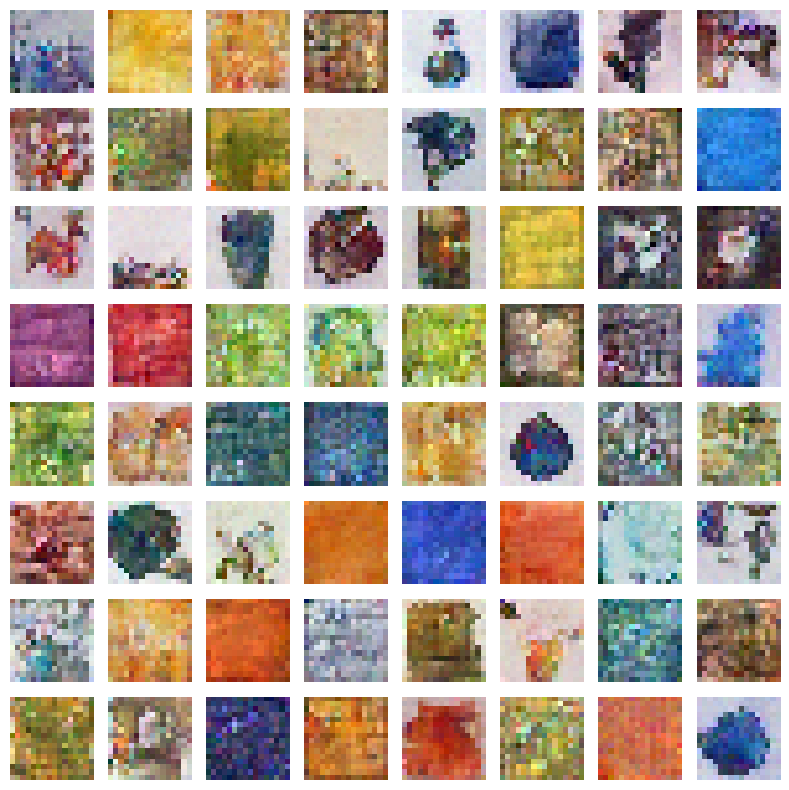

In [206]:
import matplotlib.pyplot as plt
import torch

# Load model
nn_model.load_state_dict(torch.load("model.pth", map_location=device))
nn_model.eval()
print("Loaded in Model")

# Generate 64 samples
samples, _ = sample_ddpm(64)  # batch of 64

# Display in 8x8 grid
plt.figure(figsize=(8, 8))
for i in range(64):  # 8x8 grid
    ax = plt.subplot(8, 8, i+1)     
    img = samples[i].permute(1, 2, 0).cpu().numpy()  # C,H,W -> H,W,C

    # Normalize to 0-1 for display
    img = (img - img.min()) / (img.max() - img.min())

    plt.imshow(img)
    plt.axis('off')

    # Remove border thickness
    for spine in ax.spines.values():
        spine.set_visible(False)

plt.tight_layout()
plt.show()
